# **Skripsi MT: SimPEG**

## **Import Library**

In [1]:
#Base Python
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as LogNorm
import ipywidgets
import os
import pandas as pd
from __future__ import print_function
from glob import glob

#tools simpeg
import discretize
from SimPEG import electromagnetics
from SimPEG import survey
from SimPEG import utils


#solver
try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

from SimPEG import (
    Data, maps, data_misfit, regularization, optimization, inverse_problem,
    inversion, directives
)
from SimPEG.regularization import sparse

#Modul Magnetotellurik
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.electromagnetics import natural_source as NSEM

#Math LIB
from scipy.constants import mu_0, epsilon_0
import scipy.sparse as sp

from matplotlib import rcParams
rcParams["font.size"] = 14

# **Import data ".edi"**

In [3]:
dir_list = os.listdir()
print(dir_list)

['.android', '.atom', '.conda', '.condarc', '.continuum', '.dotnet', '.Geoscience ANALYST logs', '.gitconfig', '.idlerc', '.ipynb_checkpoints', '.ipython', '.jupyter', '.matplotlib', '.Origin', '.phet', '.QtWebEngineProcess', '.spyder-py3', '.vscode', '3D Objects', 'anaconda3', 'ansel', 'AppData', 'Apple', 'Application Data', 'ChartNexus', 'CODINGMTCOBA2.ipynb', 'Contacts', 'Cookies', 'coprod2_edi.zip', 'Creative Cloud Files', 'Desktop', 'Documents', 'Downloads', 'Dropbox', 'Favorites', 'geometry.pdf', 'Google Drive', 'IntelGraphicsProfiles', 'Jedi', 'JupyterThemes.ipynb', 'latihan.ipynb', 'Links', 'Local Settings', 'mercurial.ini', 'MicrosoftEdgeBackups', 'mtpy', 'MT_CODING.ipynb', 'Music', 'My Documents', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{194cc42a-fce8-11ea-8105-d64b8ec8a086}.TM.blf', 'NTUSER.DAT{194cc42a-fce8-11ea-8105-d64b8ec8a086}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{194cc42a-fce8-11ea-8105-d64b8ec8a086}.TMContainer0000

In [4]:
r_data = 'png.1-8.edi'

In [5]:
with open(r_data) as f:
    print (f.read())

                                                                                
>HEAD                                                                           
    DATAID=KUBE91/101/108                                                       
    ACQBY="ZEPHYR GEO"                                                          
    FILEBY="ZEPHYR GEO"                                                         
    ACQDATE=07/20/91                                                            
    FILEDATE=03/01/94                                                           
    PROSPECT=KUBE91                                                             
    LOC=KUBE91-005                                                              
    LAT=-06:38:21                                                               
    LONG=+143:34:45                                                             
    ELEV=800                                                                    
    STDVERS="SEG 1.01"      

In [6]:
for py in glob("*.edi"):
    print(py)

pc5000c.edi
png.1-8.edi


In [7]:
ediFileList = glob(".\pc5000c.edi")
EDIfiles = NSEM.utils.EDIimporter(ediFileList)
EDIfiles.importFiles()

In [3]:
EDIfiles()

NameError: name 'EDIfiles' is not defined

In [9]:
data = EDIfiles()

# **Konversi data ".edi" menjadi sebuah objek penelitian**

In [10]:
MTobs = NSEM.Data.fromRecArray(EDIfiles._data)

In [11]:
d_obs, freqArr, rxT = NSEM.utils.extract_data_info(MTobs)

C:\ProgramData\Anaconda3\lib\site-packages\SimPEG\utils\code_utils.py:413: FutureWarning: freq has been deprecated, please use frequency. It will be removed in version 0.16.0 of SimPEG.
  warnings.warn(message, FutureWarning)


# **Set up SURVEY**

In [12]:
survey = MTobs.survey
survey.dobs = d_obs

In [13]:
obsData = NSEM.Data(survey,survey.dobs)

# **Set up Half-space Model**

In [20]:
M = discretize.TensorMesh(
    [
        [(100, 9, -1.5), (100.0, 13), (100, 9, 1.5)],
        [(100, 9, -1.5), (100.0, 13), (100, 9, 1.5)],
        [(50, 10, -1.6), (50.0, 10), (50, 6, 2)],
    ],
    x0=["C", "C", -14926.8217],
)

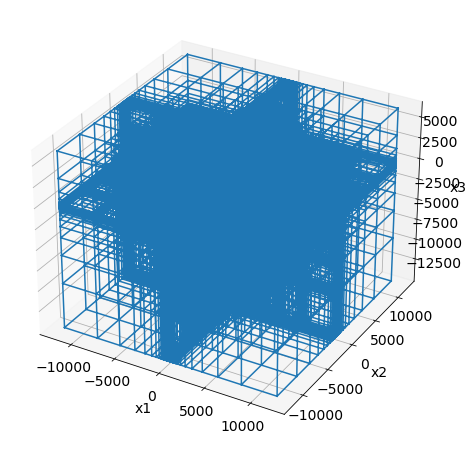

In [21]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
M.plot_grid(ax=ax, edges=False, centers=False);

In [16]:
M

TensorMesh: 24,986 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     31    -11,883.01     11,883.01    100.00  3,844.34    1.50
   y     31    -11,883.01     11,883.01    100.00  3,844.34    1.50
   z     26    -14,926.82      6,400.00     50.00  5,497.56    2.00

In [17]:
count = {'numCells':M.nC,
         'numCells_xDir':M.nCx,
         'numCells_yDir':M.nCy,
         'numCells_zDir':M.nCz,
         'numCells_vector':M.vnC}
print ('This mesh has %(numCells)d cells, which is %(numCells_xDir)d*%(numCells_yDir)d*%(numCells_zDir)d'%(count))

This mesh has 24986 cells, which is 31*31*26


In [32]:
sigma1d = np.ones((M.nC,)) * 0.1
sigBG = sigma1d[M.nC > 2] = 1e-8

# **Membuat penugasan pada coding**

In [33]:
problem = NSEM.Simulation3DPrimarySecondary(
    M, survey=survey, solver=Solver, sigma=sigma1d, sigmaPrimary=sigBG
)

ValidationError: Initialization failed:
- The Instance property 'survey' of a Simulation3DPrimarySecondary instance must be an instance of Survey. An invalid value of <module 'SimPEG.survey' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\SimPEG\\survey.py'> <class 'module'> was specified. (The List property 'source_list' of a Survey instance must be a list (each item is an instance of BaseFDEMSrc). An invalid value of <module 'SimPEG.survey' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\SimPEG\\survey.py'> <class 'module'> was specified.)